# **Milestone 5: Advanced Model Development**

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cleaned_df=pd.read_csv('cleaned_dynamic_pricing.csv')

**Training -80% , Testing -20% split**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df.drop(columns=['Historical_Cost_of_Ride']),cleaned_df['Historical_Cost_of_Ride'],test_size=0.2, random_state=42)

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord_loyalty', OrdinalEncoder(categories=[['Regular', 'Silver', 'Gold']]), ['Customer_Loyalty_Status']),
        ('ord_vehicle', OrdinalEncoder(categories=[['Economy', 'Premium']]), ['Vehicle_Type']),
        ('onehot', OneHotEncoder(sparse_output=False, drop='first', dtype=np.int32), ['Location_Category', 'Time_of_Booking']),
        ('scale', StandardScaler(), ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration']) # Explicitly list numeric features to scale
    ],
    remainder='passthrough'
)


## **XGBoost**

In [5]:
# ---- Define model ----
trf5 = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=7,
    random_state=42,
    verbosity=0
)

In [6]:

#pipeline combining preprocessing and model
pipe_XGB = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', trf5)
])

print("Consolidated preprocessor and pipeline created.")

Consolidated preprocessor and pipeline created.


In [7]:
# Use the consolidated pipeline
pipe_XGB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_loyalty',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Silver',
                                                                              'Gold']]),
                                                  ['Customer_Loyalty_Status']),
                                                 ('ord_vehicle',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Premium']]),
                                                  ['Vehicle_Type']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [8]:
y_pred_xgb = pipe_XGB.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

XGBoost Test RMSE: 77.1017, MAE: 56.3110, R2: 0.8370


In [9]:
param_grid = {
    'xgb__n_estimators': [100, 300, 400],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__gamma': [0, 0.1, 0.2]
}

In [10]:
grid_search = GridSearchCV(estimator=pipe_XGB, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_loyalty',
                                                                         OrdinalEncoder(categories=[['Regular',
                                                                                                     'Silver',
                                                                                                     'Gold']]),
                                                                         ['Customer_Loyalty_Status']),
                                                                        ('ord_vehicle',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Premium']]),
                                                                         ['Vehicle_Type']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype=<class...
                                                     max_depth=7,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=200,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'xgb__gamma': [0, 0.1, 0.2],
                         'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 5, 7, 9],
                         'xgb__n_estimators': [100, 300, 400]},
             scoring='neg_mean_squared_error')

In [12]:
best_model = grid_search.best_estimator_
y_pred_xgb_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_best = r2_score(y_test, y_pred_xgb_best)

print(f"Best XGBoost Test RMSE: {rmse_best:.4f}")
print(f"Best XGBoost Test MAE: {mae_best:.4f}")
print(f"Best XGBoost Test R2: {r2_best:.4f}")

Best XGBoost Test RMSE: 69.9682
Best XGBoost Test MAE: 52.9351
Best XGBoost Test R2: 0.8657


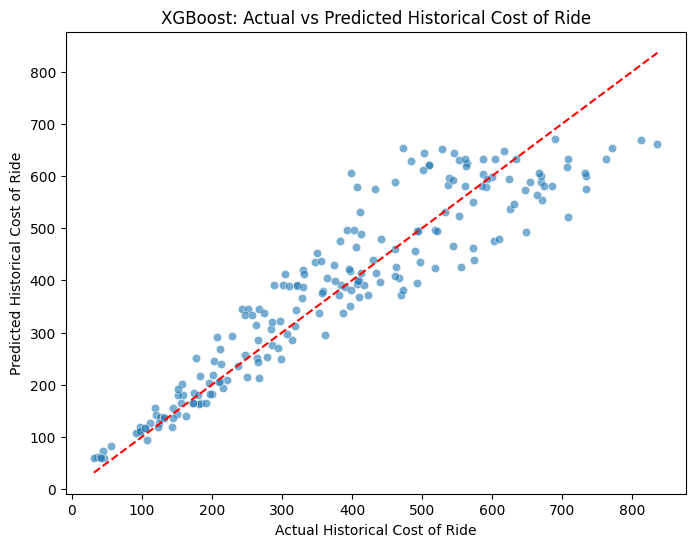

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Historical Cost of Ride')
plt.ylabel('Predicted Historical Cost of Ride')
plt.title('XGBoost: Actual vs Predicted Historical Cost of Ride')
plt.show()

 ## **LightGBM**

In [14]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [15]:
# ---- Define LightGBM model ----

lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=7,
    random_state=42,
    verbosity=0
)

In [16]:
# Pipeline combining preprocessing and LightGBM model
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])

print("Consolidated preprocessor and LightGBM pipeline created.")

Consolidated preprocessor and LightGBM pipeline created.


In [17]:
pipe_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_loyalty',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Silver',
                                                                              'Gold']]),
                                                  ['Customer_Loyalty_Status']),
                                                 ('ord_vehicle',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Premium']]),
                                                  ['Vehicle_Type']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output=False),
                                                  ['Location_Category',
                                                   'Time_of_Booking']),
                                                 ('scale', StandardScaler(),
                                                  ['Number_of_Riders',
                                                   'Number_of_Drivers',
                                                   'Number_of_Past_Rides',
                                                   'Average_Ratings',
                                                   'Expected_Ride_Duration'])])),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.03, max_depth=7,
                               n_estimators=200, random_state=42,
                               verbosity=0))])

In [18]:
# Defining the parameter grid for LightGBM
param_grid_lgbm = {
    'lgbm__n_estimators': [100,300],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__num_leaves': [31, 63, 127] 
}

# Setup GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=pipe_lgbm, param_grid=param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

print("GridSearchCV for LightGBM setup.")

GridSearchCV for LightGBM setup.


In [19]:
# Fit GridSearchCV to the training data
print("Starting LightGBM hyperparameter tuning...")
grid_search_lgbm.fit(X_train, y_train)
print("LightGBM hyperparameter tuning finished.")

# Get the best model
best_lgbm_model = grid_search_lgbm.best_estimator_

print(f"\nBest parameters found: {grid_search_lgbm.best_params_}")

# Evaluate the best model on the test set
y_pred_best_lgbm = best_lgbm_model.predict(X_test)

rmse_best_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_best_lgbm))
mae_best_lgbm = mean_absolute_error(y_test, y_pred_best_lgbm)
r2_best_lgbm = r2_score(y_test, y_pred_best_lgbm)

print(f"\nBest LightGBM Test RMSE: {rmse_best_lgbm:.4f}")
print(f"Best LightGBM Test MAE: {mae_best_lgbm:.4f}")
print(f"Best LightGBM Test R2: {r2_best_lgbm:.4f}")

Starting LightGBM hyperparameter tuning...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


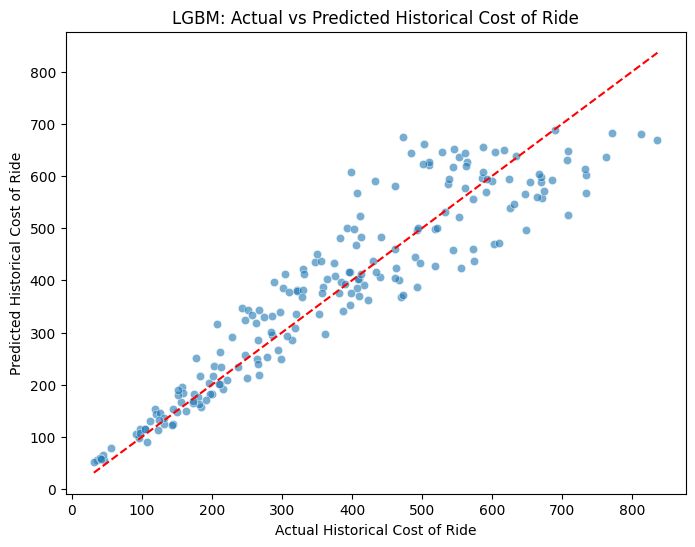

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best_lgbm, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Historical Cost of Ride')
plt.ylabel('Predicted Historical Cost of Ride')
plt.title('LGBM: Actual vs Predicted Historical Cost of Ride')
plt.show()

## **Back Testing**

In [21]:
def time_multiplier_map():
    return {
        "Morning": 1.10,
        "Afternoon": 1.00,
        "Evening": 1.10,
        "Night": 1.05
    }

def inventory_multiplier(riders, drivers):
    # Simple inventory-based pricing: increase when riders >> drivers, discount when drivers >>riders
    drivers = max(1, drivers)
    ratio = riders / drivers
    if ratio > 2.0:
        return 1.15
    if ratio > 1.5:
        return 1.10
    if ratio < 0.7:
        return 0.90
    return 1.00

# Use test set only for revenue calculations: replace cleaned_df with combined X_test + y_test
test_df = X_test.copy()
test_df['Historical_Cost_of_Ride'] = y_test
cleaned_df = test_df

def apply_rule_based_pricing(df, elasticity=-0.5):
    """
    elasticity: price elasticity of demand (negative). Example -0.5 means 10% price increase -> 5% drop in quantity.
    """
    tmap = time_multiplier_map()
    df = df.copy()
    # baseline assumptions
    df['base_price'] = df['Historical_Cost_of_Ride']
    df['base_qty'] = df['Number_of_Riders'].astype(float)
    # To compute multipliers and new price
    df['time_mult'] = df['Time_of_Booking'].map(tmap).fillna(1.0) # default 1.0 if missing
    df['inv_mult'] = df.apply(lambda r: inventory_multiplier(r['Number_of_Riders'], r['Number_of_Drivers']), axis=1)
    df['price_mult'] = df['time_mult'] * df['inv_mult']
    df['dyn_price'] = df['base_price'] * df['price_mult']
    #  new_qty = base_qty * (dyn_price / base_price) ** elasticity
    df['price_ratio'] = df['dyn_price'] / df['base_price'].replace(0, np.nan) # to avoid division by zero
    df['qty_mult'] = df['price_ratio'].fillna(1.0) ** elasticity
    df['dyn_qty'] = df['base_qty'] * df['qty_mult']
    # revenues
    df['base_revenue'] = df['base_price'] * df['base_qty']
    df['dyn_revenue'] = df['dyn_price'] * df['dyn_qty']
    # aggregate metrics
    total_base_rev = df['base_revenue'].sum()
    total_dyn_rev = df['dyn_revenue'].sum()
    revenue_lift_pct = ((total_dyn_rev - total_base_rev) / total_base_rev) * 100
    results = {
        'total_base_revenue': total_base_rev,
        'total_dynamic_revenue': total_dyn_rev,
        'revenue_lift_pct': revenue_lift_pct
    }
    return df, results

# Run the rule-based engine on the cleaned dataset
results_df, sim_metrics = apply_rule_based_pricing(cleaned_df, elasticity=-0.5)

print(f"Static total revenue: {sim_metrics['total_base_revenue']:.2f}")
print(f"Rule-based total revenue: {sim_metrics['total_dynamic_revenue']:.2f}")
print(f"Simulated revenue lift: {sim_metrics['revenue_lift_pct']:.2f}% (elasticity = -0.5)")

# Breakdown by Time_of_Booking to inspect where lift occurs
time_summary = results_df.groupby('Time_of_Booking')[['base_revenue', 'dyn_revenue']].sum()
time_summary['lift_pct'] = ((time_summary['dyn_revenue'] - time_summary['base_revenue']) / time_summary['base_revenue']) * 100
print("\nRevenue breakdown by Time_of_Booking:")
print(time_summary)

results_df.head()

Static total revenue: 4470637.44
Rule-based total revenue: 4847647.09
Simulated revenue lift: 8.43% (elasticity = -0.5)

Revenue breakdown by Time_of_Booking:
                 base_revenue   dyn_revenue   lift_pct
Time_of_Booking                                       
Afternoon        1.224514e+06  1.283195e+06   4.792177
Evening          9.577727e+05  1.062267e+06  10.910157
Morning          1.049546e+06  1.166241e+06  11.118620
Night            1.238805e+06  1.335944e+06   7.841369


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,base_qty,time_mult,inv_mult,price_mult,dyn_price,price_ratio,qty_mult,dyn_qty,base_revenue,dyn_revenue
521,38,8,Urban,Silver,78,3.57,Night,Economy,114,470.269024,...,38.0,1.05,1.15,1.2075,567.849846,1.2075,0.910032,34.581197,17870.222901,19636.927619
737,83,18,Urban,Gold,12,4.98,Morning,Economy,81,286.409294,...,83.0,1.10,1.15,1.2650,362.307757,1.2650,0.889108,73.796001,23771.971434,26736.863722
740,22,7,Urban,Gold,15,3.53,Evening,Premium,180,552.269375,...,22.0,1.10,1.15,1.2650,698.620759,1.2650,0.889108,19.560386,12149.926244,13665.291629
660,29,13,Suburban,Gold,44,4.29,Evening,Premium,87,267.740417,...,29.0,1.10,1.15,1.2650,338.691628,1.2650,0.889108,25.784145,7764.472093,8732.874041
411,91,14,Suburban,Silver,19,4.78,Night,Premium,19,111.112715,...,91.0,1.05,1.15,1.2075,134.168603,1.2075,0.910032,82.812867,10111.257060,11110.886760


**Result with the trained XGBoost model**

In [22]:
def time_multiplier_map():
    return {
        "Morning": 1.10,
        "Afternoon": 1.00,
        "Evening": 1.10,
        "Night": 1.05
    }

def inventory_multiplier(riders, drivers):
    # Simple inventory-based pricing: increase when riders >> drivers, discount when drivers >>riders
    drivers = max(1, drivers)
    ratio = riders / drivers
    if ratio > 2.0:
        return 1.15
    if ratio > 1.5:
        return 1.10
    if ratio < 0.7:
        return 0.90
    return 1.00

def apply_ml_pricing_xgb(df, model, elasticity=-0.5):
    df = df.copy()

    feature_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
                    'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
                    'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration']
    X_predict = df[feature_cols]

    X_predict_transformed = model.named_steps['preprocessor'].transform(X_predict)

    # Predict a baseline ML price
    df['ml_base_price_xgb'] = model.named_steps['xgb'].predict(X_predict_transformed)

    # Calculate dynamic multipliers similar to rule-based pricing
    tmap = time_multiplier_map()
    df['time_mult'] = df['Time_of_Booking'].map(tmap).fillna(1.0)
    df['inv_mult'] = df.apply(lambda r: inventory_multiplier(r['Number_of_Riders'], r['Number_of_Drivers']), axis=1)

    # Apply dynamic multipliers to the ML baseline price
    df['ml_dyn_price_xgb'] = df['ml_base_price_xgb'] * df['time_mult'] * df['inv_mult']

    # Calculate baseline metrics
    df['base_price'] = df['Historical_Cost_of_Ride']
    df['base_qty'] = df['Number_of_Riders'].astype(float)
    df['base_revenue'] = df['base_price'] * df['base_qty']

    # Simulate new quantity based on price elasticity of demand with the dynamic ML price
    df['price_ratio_xgb'] = df['ml_dyn_price_xgb'] / df['base_price'].replace(0, np.nan)
    df['qty_mult_xgb'] = df['price_ratio_xgb'].fillna(1.0) ** elasticity
    df['ml_qty_xgb'] = df['base_qty'] * df['qty_mult_xgb']

    # Calculate dynamic revenue
    df['ml_revenue_xgb'] = df['ml_dyn_price_xgb'] * df['ml_qty_xgb']

    total_base_rev = df['base_revenue'].sum()
    total_ml_rev_xgb = df['ml_revenue_xgb'].sum()
    revenue_lift_pct_xgb = ((total_ml_rev_xgb - total_base_rev) / total_base_rev) * 100

    results = {
        'total_base_revenue': total_base_rev,
        'total_ml_revenue_xgb': total_ml_rev_xgb,
        'revenue_lift_pct_xgb': revenue_lift_pct_xgb
    }
    return df, results

**Result with the trained LGBM**

In [23]:
def apply_ml_pricing_lgbm(df, model, elasticity=-0.5):
    df = df.copy()

    feature_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
                    'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
                    'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration']
    X_predict = df[feature_cols]

    X_predict_transformed = model.named_steps['preprocessor'].transform(X_predict)

    # Predict a baseline ML price
    df['ml_base_price'] = model.named_steps['lgbm'].predict(X_predict_transformed)

    # Calculate dynamic multipliers similar to rule-based pricing
    tmap = time_multiplier_map()
    df['time_mult'] = df['Time_of_Booking'].map(tmap).fillna(1.0)
    df['inv_mult'] = df.apply(lambda r: inventory_multiplier(r['Number_of_Riders'], r['Number_of_Drivers']), axis=1)

    # Apply dynamic multipliers to the ML baseline price
    df['ml_dyn_price'] = df['ml_base_price'] * df['time_mult'] * df['inv_mult']

    # Calculate baseline metrics
    df['base_price'] = df['Historical_Cost_of_Ride']
    df['base_qty'] = df['Number_of_Riders'].astype(float)
    df['base_revenue'] = df['base_price'] * df['base_qty']

    # Simulate new quantity based on price elasticity of demand with the dynamic ML price
    df['price_ratio'] = df['ml_dyn_price'] / df['base_price'].replace(0, np.nan)
    df['qty_mult'] = df['price_ratio'].fillna(1.0) ** elasticity
    df['ml_qty'] = df['base_qty'] * df['qty_mult']

    # Calculate dynamic revenue
    df['ml_revenue'] = df['ml_dyn_price'] * df['ml_qty']

    total_base_rev = df['base_revenue'].sum()
    total_ml_rev = df['ml_revenue'].sum()
    revenue_lift_pct = ((total_ml_rev - total_base_rev) / total_base_rev) * 100

    results = {
        'total_base_revenue': total_base_rev,
        'total_ml_revenue': total_ml_rev,
        'revenue_lift_pct': revenue_lift_pct
    }
    return df, results

--- Running Hybrid XGBoost Simulation ---

--- XGBoost Hybrid Simulation with Elasticity = -0.9 ---
Static total revenue: 4470637.44
ML-Dynamic total revenue (XGBoost): 4543080.70
Simulated revenue lift (XGBoost Hybrid): 1.62%

--- XGBoost Hybrid Simulation with Elasticity = -0.5 ---
Static total revenue: 4470637.44
ML-Dynamic total revenue (XGBoost): 4860270.54
Simulated revenue lift (XGBoost Hybrid): 8.72%

XGBoost Hybrid ML Predicted Price vs Historical Base Price Statistics:
       Historical_Cost_of_Ride  ml_dyn_price_xgb
count               200.000000        200.000000
mean                379.594877        452.209715
std                 191.426286        210.818579
min                  31.565676         65.481891
25%                 213.124069        272.391716
50%                 382.247753        467.637810
75%                 534.172365        609.540353
max                 836.116419        847.540117

Head of XGBoost Hybrid ML Results DataFrame (using elasticity = 0.5):


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,time_mult,inv_mult,ml_dyn_price_xgb,base_price,base_qty,base_revenue,price_ratio_xgb,qty_mult_xgb,ml_qty_xgb,ml_revenue_xgb
521,38,8,Urban,Silver,78,3.57,Night,Economy,114,470.269024,...,1.05,1.15,449.153113,470.269024,38.0,17870.222901,0.955098,1.023236,38.882983,17464.412886
737,83,18,Urban,Gold,12,4.98,Morning,Economy,81,286.409294,...,1.10,1.15,349.539675,286.409294,83.0,23771.971434,1.220420,0.905202,75.131733,26261.521561
740,22,7,Urban,Gold,15,3.53,Evening,Premium,180,552.269375,...,1.10,1.15,796.660542,552.269375,22.0,12149.926244,1.442522,0.832605,18.317302,14592.671795
660,29,13,Suburban,Gold,44,4.29,Evening,Premium,87,267.740417,...,1.10,1.15,436.301426,267.740417,29.0,7764.472093,1.629569,0.783364,22.717558,9911.703042
411,91,14,Suburban,Silver,19,4.78,Night,Premium,19,111.112715,...,1.05,1.15,152.412853,111.112715,91.0,10111.257060,1.371696,0.853829,77.698471,11842.245733


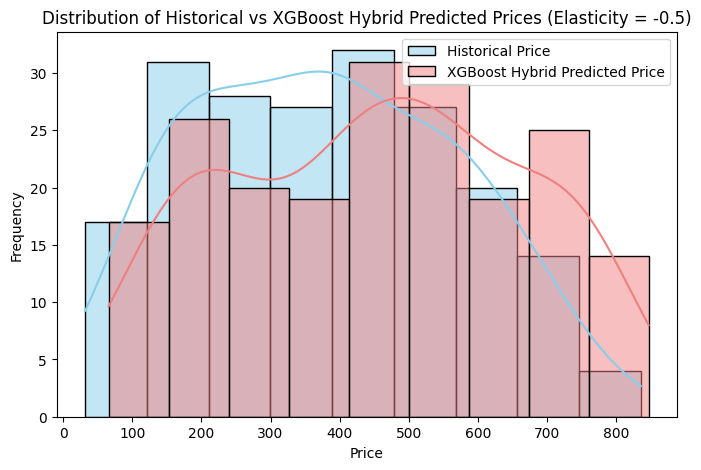


--- Running Hybrid LightGBM Simulation ---

--- LightGBM Hybrid Simulation with Elasticity = -0.9 ---
Static total revenue: 4470637.44
ML-Dynamic total revenue (LightGBM): 4544464.51
Simulated revenue lift (LightGBM Hybrid): 1.65%

--- LightGBM Hybrid Simulation with Elasticity = -0.5 ---
Static total revenue: 4470637.44
ML-Dynamic total revenue (LightGBM): 4867902.53
Simulated revenue lift (LightGBM Hybrid): 8.89%

LightGBM Hybrid ML Predicted Price vs Historical Base Price Statistics:
       Historical_Cost_of_Ride  ml_dyn_price
count               200.000000    200.000000
mean                379.594877    453.090846
std                 191.426286    213.775786
min                  31.565676     62.657616
25%                 213.124069    270.453412
50%                 382.247753    460.492354
75%                 534.172365    622.078374
max                 836.116419    869.546354

Head of LightGBM Hybrid ML Results DataFrame (using elasticity= -0.5):


c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\Dynamic-Pricing\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,time_mult,inv_mult,ml_dyn_price,base_price,base_qty,base_revenue,price_ratio,qty_mult,ml_qty,ml_revenue
521,38,8,Urban,Silver,78,3.57,Night,Economy,114,470.269024,...,1.05,1.15,445.236622,470.269024,38.0,17870.222901,0.946770,1.027727,39.053624,17388.103748
737,83,18,Urban,Gold,12,4.98,Morning,Economy,81,286.409294,...,1.10,1.15,373.501492,286.409294,83.0,23771.971434,1.304083,0.875684,72.681767,27146.748327
740,22,7,Urban,Gold,15,3.53,Evening,Premium,180,552.269375,...,1.10,1.15,804.623523,552.269375,22.0,12149.926244,1.456940,0.828474,18.226438,14665.420629
660,29,13,Suburban,Gold,44,4.29,Evening,Premium,87,267.740417,...,1.10,1.15,434.020521,267.740417,29.0,7764.472093,1.621050,0.785420,22.777174,9885.760788
411,91,14,Suburban,Silver,19,4.78,Night,Premium,19,111.112715,...,1.05,1.15,157.671796,111.112715,91.0,10111.257060,1.419026,0.839469,76.391716,12044.819029


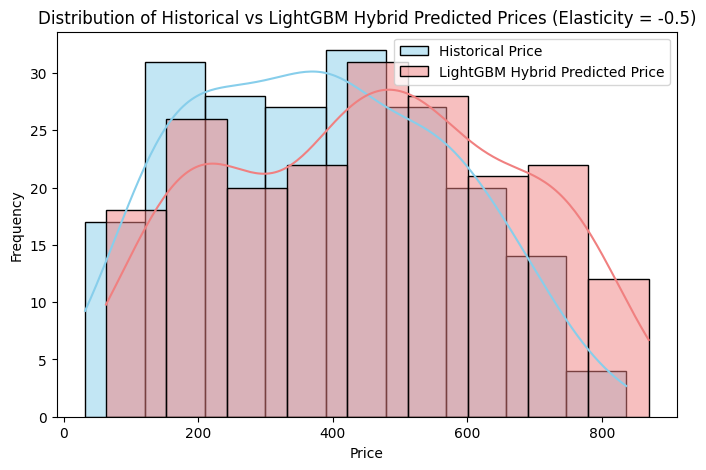


--- Comparison with Rule-based Engine (Elasticity = -0.5) ---
Rule-based total revenue: 4847647.09
Simulated revenue lift (Rule-based): 8.43%


In [24]:
print('--- Running Hybrid XGBoost Simulation ---')
elasticity_values = [-0.9, -0.5] # Example elasticity values

for elasticity in elasticity_values:
    ml_results_df_xgb, ml_sim_metrics_xgb = apply_ml_pricing_xgb(cleaned_df, best_model, elasticity=elasticity)

    print(f"\n--- XGBoost Hybrid Simulation with Elasticity = {elasticity} ---")
    print(f"Static total revenue: {ml_sim_metrics_xgb['total_base_revenue']:.2f}")
    print(f"ML-Dynamic total revenue (XGBoost): {ml_sim_metrics_xgb['total_ml_revenue_xgb']:.2f}")
    print(f"Simulated revenue lift (XGBoost Hybrid): {ml_sim_metrics_xgb['revenue_lift_pct_xgb']:.2f}%")

# Add analysis of predicted prices (using the elasticity value = -0.5)
print("\nXGBoost Hybrid ML Predicted Price vs Historical Base Price Statistics:")
print(ml_results_df_xgb[['Historical_Cost_of_Ride', 'ml_dyn_price_xgb']].describe())

# Display head of the results dataframe (using the elasticity value = -0.5)
print("\nHead of XGBoost Hybrid ML Results DataFrame (using elasticity = 0.5):")
display(ml_results_df_xgb.head())

# Add visualization to compare price distributions
plt.figure(figsize=(8, 5))
sns.histplot(ml_results_df_xgb['Historical_Cost_of_Ride'], color='skyblue', label='Historical Price', kde=True)
sns.histplot(ml_results_df_xgb['ml_dyn_price_xgb'], color='lightcoral', label='XGBoost Hybrid Predicted Price', kde=True)
plt.title(f'Distribution of Historical vs XGBoost Hybrid Predicted Prices (Elasticity = {elasticity})')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('\n--- Running Hybrid LightGBM Simulation ---')
elasticity_values = [-0.9, -0.5] # Example elasticity values

for elasticity in elasticity_values:
    ml_results_df_lgbm, ml_sim_metrics_lgbm = apply_ml_pricing_lgbm(cleaned_df, best_lgbm_model, elasticity=elasticity)

    print(f"\n--- LightGBM Hybrid Simulation with Elasticity = {elasticity} ---")
    print(f"Static total revenue: {ml_sim_metrics_lgbm['total_base_revenue']:.2f}")
    print(f"ML-Dynamic total revenue (LightGBM): {ml_sim_metrics_lgbm['total_ml_revenue']:.2f}")
    print(f"Simulated revenue lift (LightGBM Hybrid): {ml_sim_metrics_lgbm['revenue_lift_pct']:.2f}%")

# Add analysis of predicted prices (using the elasticity value = -0.5)
print("\nLightGBM Hybrid ML Predicted Price vs Historical Base Price Statistics:")
print(ml_results_df_lgbm[['Historical_Cost_of_Ride', 'ml_dyn_price']].describe())

# Display head of the results dataframe (using the elasticity value = -0.5)
print("\nHead of LightGBM Hybrid ML Results DataFrame (using elasticity= -0.5):")
display(ml_results_df_lgbm.head())

# Add visualization to compare price distributions
plt.figure(figsize=(8, 5))
sns.histplot(ml_results_df_lgbm['Historical_Cost_of_Ride'], color='skyblue', label='Historical Price', kde=True)
sns.histplot(ml_results_df_lgbm['ml_dyn_price'], color='lightcoral', label='LightGBM Hybrid Predicted Price', kde=True)
plt.title(f'Distribution of Historical vs LightGBM Hybrid Predicted Prices (Elasticity = {elasticity})')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Final comparison with rule-based
print(f"\n--- Comparison with Rule-based Engine (Elasticity = -0.5) ---")
print(f"Rule-based total revenue: {sim_metrics['total_dynamic_revenue']:.2f}")
print(f"Simulated revenue lift (Rule-based): {sim_metrics['revenue_lift_pct']:.2f}%")

**To save the models**

In [25]:
import joblib
import os

# Create the models directory 
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Save the best XGBoost model
joblib.dump(best_model, os.path.join(models_dir, 'xgboost_best_model.pkl'))
print(f"XGBoost model saved to {os.path.join(models_dir, 'xgboost_best_model.pkl')}")

# Save the best LightGBM model
joblib.dump(best_lgbm_model, os.path.join(models_dir, 'lightgbm_best_model.pkl'))
print(f"LightGBM model saved to {os.path.join(models_dir, 'lightgbm_best_model.pkl')}")

XGBoost model saved to models\xgboost_best_model.pkl
LightGBM model saved to models\lightgbm_best_model.pkl
